# Import libraries

In [1]:
%load_ext autoreload
%autoreload 1

In [ ]:
# Importing libraries
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import libraries for listing countries
#import pycountry
#import pycountry_convert as pc

# Import aux libraries
from collections import Counter
import re
#from wordcloud import WordCloud

# Import libraries for Spacy
import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher 

# Load model for Spacy
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)

In [ ]:
# Check CUDA on torch
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is properly installed
print(torch.cuda.current_device())  # Returns the index of the current CUDA device
print(torch.cuda.get_device_name(torch.cuda.current_device())) 

In [ ]:
# Import transformers and others
from transformers import pipeline
from sentence_transformers import SentenceTransformer, SimilarityFunction, util

In [ ]:
# Import own libraries
from extract_info import extract_abstracts_bib

In [ ]:
%aimport extract_info

# Export information from bib files to excel

In [ ]:
# Create the excel file with the abstracts information
bib_directory   = '00_bibFiles'
bib_file        = 'search_001'
path_export     = extract_abstracts_bib(bib_file, bib_directory,'out')

# Load the data extracted

In [ ]:
# From the extracted information, create a dataframe
bib_file        = 'search_001'
path_export_file = os.path.join('out', bib_file+'_export.xlsx')
df_base = pd.read_excel(path_export_file)
print(df_base.columns)
print(df_base['abstract'][12])

# Data preprocess

### Get the tokens

In [ ]:
# Function to preprocess and tokenize text using spacy
def preprocess_text(doc):
    tokens = [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]
    return tokens

# Tokenize abstracts and titles and add column filtering out the stopwords
df_base['tokens_abstract']   = df_base['abstract'].apply(nlp)
df_base['tokens_title']      = df_base['title'].apply(nlp)

# Tokenize abstracts and titles and add column filtering out the stopwoordss
df_base['f_tokens_abstract'] = df_base['tokens_abstract'].apply(preprocess_text)
df_base['f_tokens_title']    = df_base['tokens_title'].apply(preprocess_text)


### Get the principal keywords of the abstracts

In [ ]:
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.SIMPLE,
        )
        return np.unique([result.get("word").strip() for result in results])

# Load pipeline
model_name = "ml6team/keyphrase-extraction-kbir-inspec"
#model_name = 'ml6team/keyphrase-generation-keybart-inspec'
extractor = KeyphraseExtractionPipeline(model=model_name, device=0)

# Fastest
model_2 = 'ml6team/keyphrase-extraction-distilbert-inspec'
extractor_2 = KeyphraseExtractionPipeline(model=model_2, device=0)


#exmaple = extractor(df_base['abstract'][1])
#print (exmaple)
example2 = extractor_2(df_base['abstract'][29])

print(example2)

for i in range(0, 10):
    print(extractor(df_base['abstract'][i]))

#df_base['keywords']= df_base['abstract'].apply(lambda x: extractor(x))


In [ ]:
summarizer = pipeline("summarization", model="Falconsai/text_summarization", device=0)
for i in range(0, 20):
    text = df_base['abstract'][i]
    print(summarizer(text, max_length=100, min_length=30, do_sample=False))
#text = df_base['abstract']
#print(text)
#print(summarizer(text, max_length=100, min_length=30, do_sample=False))

In [ ]:
item = 259
title = df_base['title'][item]
abstract = df_base['abstract'][item]
doc = nlp(abstract)
sentences = [sent.text for sent in doc.sents]

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sentence_embeddings = model.encode(sentences)
title_embedding = model.encode(title)

abstract_embeddings = np.mean(sentence_embeddings, axis=0)


# cosine similarity
abstract_scores = util.pytorch_cos_sim(sentence_embeddings, abstract_embeddings)
title_score = util.pytorch_cos_sim(sentence_embeddings, title_embedding)

doc_scores = abstract_scores.flatten()
tit_scores = title_score.flatten()

title_weight = 0.3
combined_scores = (1-title_weight)*doc_scores+tit_scores*title_weight

for i, score in enumerate(combined_scores):
    print(f"Sentence {i+1} Score: {score:.4f}")
    print(sentences[i])


In [ ]:
# Export the results to an excel file
path_export_file = os.path.join('out', bib_file+'_export_tockens.xlsx')
df_base.to_excel(path_export_file, index=True)

### Analytics of tokens

In [ ]:

# Create entities
df_base['entities_abstract'] = df_base['tokens_abstract'].apply(lambda x: [(ent.text, ent.label_) for ent in x.ents])

# Create chunks
df_base['chunks_abstract'] = df_base['tokens_abstract'].apply(lambda x: [(chunk.text, chunk.root.text) for chunk in x.noun_chunks])

In [ ]:
# Table with most common entities types
entities_list = [label for sublist in df_base['entities_abstract'] for ent, label in sublist]
entities_counter = Counter(entities_list)
df_entities = pd.DataFrame(entities_counter.items(), columns=['label', 'count'])
df_entities = df_entities.sort_values(by='count', ascending=False)
df_entities['label_desc'] = df_entities['label'].apply(lambda x: spacy.explain(x) if spacy.explain(x) else x)
df_entities.head(10)

In [ ]:
# Plot the common tokens of titles and abstracts
tokens_counter = Counter([word for sublist in df_base['f_tokens_abstract'] for word in sublist])
common_words = tokens_counter.most_common(15)

ents_counter = Counter([ent for sublist in df_base['entities_abstract'] for ent, label in sublist])
common_ents = ents_counter.most_common(15)

# Create a hbar plot of the most common filtered words
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

unfiltered_plt = ax1.barh(*zip(*common_words))
ax1.set_ylabel('Word')
ax1.set_title('Most common words')
ax1.bar_label(unfiltered_plt)

filtered_plt = ax2.barh(*zip(*common_ents))
ax2.set_ylabel('Entity')
ax2.set_title('Common entities')
ax2.bar_label(filtered_plt)

plt.show()


# Filtering Data PRISMA information

### 1. Title
- Identify from the title if the article a systematic review

In [ ]:
# Check from the tokens titles if any is 'review'
df_base['PRISMA_1_is_review'] = df_base['f_tokens_title'].apply(lambda x: 'review' in x)
df_filtered = df_base[df_base['PRISMA_1_is_review'] == True]
for index, row in df_filtered.iterrows():
    print(row['title'])


# Export the results to an excel file

In [ ]:
# From the save information, create a dataframe
bib_file        = 'search_001'
path_export_file = os.path.join('out', bib_file+'_export_tockens.xlsx')
df_base = pd.read_excel(path_export_file)
print(df_base.columns)

### 2. Objectives
- Provide an explicit statement of the main objective(s) or question(s) the review addresses
- Extract if exists a objective from the context

In [ ]:
# Function to extract sentences from a single document
def extract_sentences(text):
    doc = nlp(text)  # Process the text with spaCy
    sentences = [sent.text.strip() for sent in doc.sents]  # Extract sentences
    return sentences

#### Analisys with Q/A to find objective

In [ ]:
# Identify main sentences by applying the function to the abstracts

model_similarity = SentenceTransformer("all-MiniLM-L6-v2", similarity_fn_name=SimilarityFunction.COSINE, device=0)

def similarity_matrix(title, abstract):
    # Find the similarity between the title and the abstract
    title_embedding     = model_similarity.encode(title)

    sentences           = extract_sentences(abstract)
    sentence_embeddings = model_similarity.encode(sentences)

    abstract_embeddings = np.mean(sentence_embeddings, axis=0)

    # Calculate the cosine similarity between the title and the abstract
    abstract_scores     = util.pytorch_cos_sim(sentence_embeddings, abstract_embeddings)
    title_score         = util.pytorch_cos_sim(sentence_embeddings, title_embedding)

    # Combine the scores
    doc_scores = abstract_scores.flatten()
    tit_scores = title_score.flatten()
    
    title_weight    = 0.3
    combined_scores = (1-title_weight)*doc_scores + tit_scores*title_weight
    
    # Return the sentence with the highest similarity
    return combined_scores

# Check if it is working
df_report = df_base[['title', 'abstract']].copy()
df_report['sentences_weights'] = df_report.apply(lambda x: similarity_matrix(x['title'], x['abstract']),axis=1)

In [ ]:
df_report['sentences'] = df_report['abstract'].apply(extract_sentences)



In [ ]:
# Extract the verbs for each sentence
def look_for_verbs_dobj(abstract):
    sentences = extract_sentences(abstract)
    result = []
    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)
        verb_list = []
        for token in doc:
            if token.dep_ == 'dobj' or token.dep_ == 'nsubjpass':
                if token.head.dep_ != 'advcl':
            #if token.dep_ == 'dobj' or token.dep_ == 'nsubjpass':
            #    if token.head.dep_ == 'ROOT':
                    #value = token.head.lemma_+token.text.upper()
                    verb_list.append(token.head.lemma_+token.text.capitalize())
        result.append(verb_list)
    return result
            
df_report['verbs_objective'] = df_report['abstract'].apply(look_for_verbs_dobj)

In [ ]:
# Create a df with a list of verbs from verbs_objective
list_verbs = df_report['top_ROOT_verb'].explode().dropna()
list_verbs = list_verbs.explode().dropna().str.lower()
print(list_verbs)
# split at mayus characters
#list_verbs = list_verbs.str.split(r'[A-Z][^A-Z]*').explode().dropna()
#list_verbs = [verb for sublist in list_verbs for verb in sublist]
# Count the verbs
verbs_counter = Counter(list_verbs)
# Create a df with the verbs
df_verbs = pd.DataFrame(verbs_counter.items(), columns=['verb', 'count'])
df_verbs = df_verbs.sort_values(by='count', ascending=False)
df_verbs.head(10)

In [ ]:
# Create a df with a list of verbs from verbs_objective
list_subj = df_report['subjects'].explode().dropna()
list_subj = [subj for sublist in list_subj for subj in sublist]
# Count the verbs
subj_counter = Counter(list_subj)
# Create a df with the verbs
df_subj = pd.DataFrame(subj_counter.items(), columns=['subj', 'count'])
df_subj = df_subj.sort_values(by='count', ascending=False)
df_subj.head(10)

In [ ]:
# Extract the verbs for each sentence
def look_for_verbs_dobj(sentences):
    result = []
    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)
        verb_list = []
        for token in doc:
            if token.dep_ == 'dobj' or token.dep_ == 'nsubjpass':
                if token.head.dep_ != 'advcl':
            #if token.dep_ == 'dobj' or token.dep_ == 'nsubjpass':
            #    if token.head.dep_ == 'ROOT':
                    #value = token.head.lemma_+token.text.upper()
                    verb_list.append(token.head.lemma_+token.lemma_.capitalize())
        result.append(verb_list)
    return result

# Extract the verbs for each sentence
def look_for_verbs_ROOT(sentences):
    result = []
    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)
        verb_list = []
        for token in doc:
            if token.dep_ == 'ROOT':
                subj = [child.lemma_ for child in token.children if child.dep_ == 'nsubj']
                verb_list.append(token.lemma_)
        result.append(verb_list)
    return result

# Extract the subjects for each sentence
def look_for_subjects(sentences):
    result = []
    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)
        subj_list = []
        for token in doc:
            if token.dep_ == 'ROOT':
                subj = [child.lemma_ for child in token.children if child.dep_ == 'nsubj']
                if subj:
                    subj_list.append(subj[0])
        result.append(subj_list)
    return result

# Function to extract phrases based on semantic roles
def extract_phrase2(sentences):
    result = []
    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)
        phrase_list = []
        for token in doc:
            # Check for phrases like "in this review" based on dependency tags and part-of-speech tags
            if token.dep_ in ('prep') and token.head.dep_ == 'ROOT':
                start = token.i
                end = [child.i for child in token.children if child.dep_ == 'pobj']
                if end:
                    end = end[0]
                    phrase_list.append( ' '.join([t.text.lower() for t in doc[start:end+1]]))
        result.append(phrase_list)
    return result

#df_report['verbs_objective']    = df_report['sentences'].apply(look_for_verbs_dobj)
#df_report['verbs_ROOT']    = df_report['sentences'].apply(look_for_verbs_ROOT)
df_report['phrase_ROOT']   = df_report['sentences'].apply(extract_phrase2)
#df_report['subjects']           = df_report['sentences'].apply(look_for_subjects)





In [ ]:
# Load a pre-trained QA model and tokenizer
qa_pipeline = pipeline('question-answering', model="distilbert-base-uncased-distilled-squad", device=0)

# Function to find the objective of the paper
def objective_weights_qa(paragraph, question):
    result = qa_pipeline(question=question, context=paragraph)
    
    doc = nlp(paragraph)
    # Find whole sentence where the answer is
    for sent in doc.sents:
        if sent.start_char <= result['start'] and sent.end_char >= result['end']:
            sentence = sent.text
            break        
        else:
            sentence = 'Not found'
        
    return sentence

# Define the questions
queries = [
    "What is the objective of this paper/work/study?",
    "What does the paper/work/study analyze?",
    "What question is addressed in the paper/work/study?",
    "What research question does this study aim to answer?",
    "What is the main purpose of the paper/work/study?",
    "What this paper/work/study investigate?"
    "What does this study seek to accomplish?"   
    ]

# Apply the function to the abstracts
def matrix_QA_objective(abstract, sentences, queries):
    results = []
    for query in queries:
        sentence_result = objective_weights_qa(abstract, query)
        results.append(sentence_result)
    
    count_results = Counter(results)
    count_matrix = np.zeros(len(sentences))
    for i, sent in enumerate(sentences):
        count_matrix[i] = count_results[sent]
    
    count_matrix = count_matrix/np.sum(count_matrix) if np.sum(count_matrix) != 0 else count_matrix
    return count_matrix

# Check if it is working
##item = 0
##abstract = df_report['abstract'][item]
##sentences = df_report['sentences'][item]
##
##print(matrix_QA_objective(abstract, sentences, queries))

# Apply function to the dataframe
df_report['objective_QA_weights'] = df_report.apply(lambda x: matrix_QA_objective(x['abstract'], x['sentences'], queries), axis=1)

In [ ]:
# Create a matrix with boolean indexes if the subject is on the list
def new_weight(verbs, subjects, IN_phrase_root, QA_weights, weights):
    exclude_conlusion_verbs     = ['show', 'reveal', 'indicate', 'confirm', 'demonstrate', 'provide', 'find', 'showcase', 'highlight', 'suggest', 'achieve',
                                   'account', 'contribute', 
                                   ]
    include_subjects            = ['study', 'paper', 'work', 'research', ]
    include_IN_phrase_root      = ['in this study', 'in the current study', 'through this study', 'in the present study',
                                   'in this paper',
                                   'in this work', 'in the present work', 'through this work',
                                   'in this article', ]

    w_exclude = []
    w_inc_subj = []
    w_inc_IN = []

    for verb in verbs:
        _exclude = any([token in exclude_conlusion_verbs for token in verb])
        w_exclude.append(int(_exclude))

    for subj in subjects:
        _include = any([token in include_subjects for token in subj])
        w_inc_subj.append(int(_include))
    
    for IN_phrase in IN_phrase_root:
        _include = any([token in include_IN_phrase_root for token in IN_phrase])
        w_inc_IN.append(int(_include))

    # Matrix to identify last sentence
    last_sentence = np.zeros(len(verbs))
    last_sentence[-1] = 1

    w_exclude = np.array(w_exclude)
    w_inc_subj = np.array(w_inc_subj)
    w_inc_IN = np.array(w_inc_IN) 
    weights = weights.numpy()
    w_sbj = np.logical_or(w_inc_subj, w_inc_IN).astype(int)

    n_weights = weights*(1 + w_sbj*0.15)
    n_weights = n_weights*(1 + QA_weights*0.3) 
    n_weights = n_weights * (1 - w_exclude)
    n_weights = n_weights * (1 - last_sentence*0.2)
    #return n_weights, w_exclude, w_inc_subj, w_inc_IN, w_sbj
    return n_weights


In [ ]:

# Check if it is working
item = 20
weights = df_report['sentences_weights'][item]
in_phrase_root = df_report['phrase_ROOT'][item]
subjects = df_report['subjects'][item]
verbs = df_report['verbs_ROOT'][item]
QA_w = df_report['objective_QA_weights'][item]
n_weights, w_exclude, w_inc_subj, w_inc_IN, w_sbj = new_weight(verbs, subjects,in_phrase_root, QA_w,weights)
#
#print(n_weights)

print(weights)
print(QA_w)
print(w_sbj)
print(n_weights)



In [ ]:

df_report['n_weights'] = df_report.apply(lambda x: new_weight(x['verbs_ROOT'], x['subjects'], x['phrase_ROOT'], x['objective_QA_weights'], x['sentences_weights']), axis=1)
df_report['top_nsentence'] = df_report.apply(lambda x: x['sentences'][np.argmax(x['n_weights'])], axis=1)
df_report['top_verb'] = df_report.apply(lambda x: x['verbs_objective'][np.argmax(x['n_weights'])], axis=1)
df_report['top_ROOT_verb'] = df_report.apply(lambda x: x['verbs_ROOT'][np.argmax(x['n_weights'])], axis=1)

# Top Sentence with weights
df_report_check = df_base[['title']].copy()

# With sentence_weights
df_report_check['top_sentence_w']   = df_report.apply(lambda x: x['sentences'][np.argmax(x['sentences_weights'])], axis=1)
df_report_check['top_ROOT_w']       = df_report.apply(lambda x: x['verbs_ROOT'][np.argmax(x['sentences_weights'])], axis=1)

# With objective_QA_weights
df_report_check['top_sentence_QA']   = df_report.apply(lambda x: x['sentences'][np.argmax(x['objective_QA_weights'])], axis=1)
df_report_check['top_ROOT_QA']       = df_report.apply(lambda x: x['verbs_ROOT'][np.argmax(x['objective_QA_weights'])], axis=1)

# With n_weights
df_report_check['top_sentence_n']   = df_report.apply(lambda x: x['sentences'][np.argmax(x['n_weights'])], axis=1)
df_report_check['top_ROOT_n']       = df_report.apply(lambda x: x['verbs_ROOT'][np.argmax(x['n_weights'])], axis=1)

# Check if top_nsentence is equal to top sentence
df_report_check['is_equal'] = df_report_check['top_sentence_QA'] == df_report_check['top_sentence_w']
df_report_check['is_last'] = df_report['n_weights'].apply(np.argmax)==df_report['n_weights'].apply(len)-1

In [ ]:

# Export the results to an excel file
path_export_file = os.path.join('out', bib_file+'_export_tockens_part2.xlsx')
df_report_check.to_excel(path_export_file, index=True)

In [ ]:
item_exp = 157
abstract = df_report['abstract'][item_exp]
w_exp = df_report['n_weights'][item_exp]
verbs = df_report['verbs_ROOT'][item_exp]
subjects = df_report['subjects'][item_exp]
item = np.argmax(w_exp).item()

print(item, verbs[item])
for i, sentence in enumerate(extract_sentences(abstract)):
    print(i, f'{w_exp[i]*100:,.1f}', verbs[i], subjects[i])
    print(sentence)


In [ ]:
def extract_phrase2(sentences):
    result = []
    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)
        phrase_list = []
        for token in doc:
            # Check for phrases like "in this review" based on dependency tags and part-of-speech tags
            if token.dep_ in ('prep') and token.head.dep_ == 'ROOT':
                start = token.i
                end = [child.i for child in token.children if child.dep_ == 'pobj']
                if end:
                    end = end[0]
                    phrase_list.append( ' '.join([t.lemma_.lower() for t in doc[start:end+1]]))
        result.append(phrase_list)
    return result

txt = ['For this production pathway, a high renewable energy potential, especially in solar energy, is crucial.']

print(extract_phrase2(txt))


In [ ]:
text = 'We conclude that H2 geo-storage in deep coal seams is feasible from a fundamental petro-physical perspective; this work thus aids in the large-scale implementation of a hydrogen economy.'
doc = nlp(text)

for token in doc:
    # if token is verb
    if token.dep_ == 'dobj' or token.dep_ == 'nsubjpass':
        print(token.head.text, token.text)

for token in doc:
    # if token is verb
    if token.dep_ == 'ROOT':
        subj = [child.lemma_ for child in token.children if child.dep_ == 'nsubj']
        print(token.lemma_, subj)

displacy.render(doc, style='dep', jupyter=True)


In [ ]:
# Load a pre-trained QA model and tokenizer
qa_pipeline = pipeline('question-answering', model="distilbert-base-uncased-distilled-squad", device=0)

# Function to find the objective of the paper
def objective_finder_qa(paragraph, question):
    result = qa_pipeline(question=question, context=paragraph)
    
    doc = nlp(paragraph)
    # Find whole sentence where the answer is
    for sent in doc.sents:
        if sent.start_char <= result['start'] and sent.end_char >= result['end']:
            sentence = sent.text
            break        
        else:
            sentence = 'Not found'
        
    return result['answer'], sentence

# Define the question to be asked
queries = [
    "What is the objective of this paper/work/study?",
    "What does the paper/work/study analyze?",
    "What question is addressed in the paper/work/study?",
    "What research question does this study aim to answer?",
    "What is the main purpose of the paper/work/study?",
    "What this paper/work/study investigate?"
    "What does this study seek to accomplish?"   
    ]

for i in range(len(queries)):
   df_base[f'QA_objective_{i+1}'] = df_base['abstract'].apply(objective_finder_qa, question=queries[i])


In [ ]:
# Check the results
df_base.columns


### Clustering

In [ ]:
# From the save information, create a dataframe
bib_file        = 'search_001'
path_export_file = os.path.join('out', bib_file+'_export_tockens_part2.xlsx')
df_report_check = pd.read_excel(path_export_file)
print(df_report_check.columns)

In [ ]:
# Tokens to be used
df_report_check['tokens_objective'] = df_report_check['top_sentence_n'].apply(extractor)

In [ ]:
# Clustering
#import umap
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

model = SentenceTransformer("all-MiniLM-L6-v2", similarity_fn_name=SimilarityFunction.COSINE, device=0)

df_report_check['for_clustering'] = df_report_check.apply(lambda x: '. '.join([x['title'], x['top_sentence_w']]), axis=1)
#df_report_check['for_clustering'] = df_base['abstract']

sentences = df_report_check['for_clustering']
embeddings = model.encode(sentences)

#reduce the dimensionality of the embeddings
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=1, metric='cosine').fit_transform(embeddings)

# perform clustering on the reduced embeddings
cluster = hdbscan.HDBSCAN(min_cluster_size=8, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

# extract the cluster labels
df_report_check['cluster'] = cluster.labels_



cluster_labels = cluster.labels_

# Calculate silhouette scores
silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
sample_silhouette_values = silhouette_samples(umap_embeddings, cluster_labels)

# Plot silhouette scores
def plot_silhouette(umap_embeddings, cluster_labels, sample_silhouette_values, silhouette_avg):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 8)
    
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(umap_embeddings) + (len(set(cluster_labels)) + 1) * 10])

    y_lower = 10
    for i in range(len(set(cluster_labels))):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

# Plot the silhouette scores
plot_silhouette(umap_embeddings, cluster_labels, sample_silhouette_values, silhouette_avg)

In [ ]:
# Print tokens of the clusters
tokens = df_report_check['tokens_objective']

# Topic modeling
from collections import defaultdict

# group texts by cluster
cluster_texts = defaultdict(list)
for _tokens, label in zip(tokens, cluster_labels):
    cluster_texts[label].append(_tokens)

# Get the more representative tokens of each cluster
def get_representative_tokens(tokens):
    # Flatten the list of tokens
    ents = [ent for sublist in tokens for ent in sublist]
    # Count the tokens
    token_counts = Counter(ents)
    # Get the most common tokens
    common_tokens = token_counts.most_common(10)
    return common_tokens

# Get the most representative tokens for each cluster
cluster_representative_tokens = {
    label: get_representative_tokens(tokens) for label, tokens in cluster_texts.items()
}
# Print the most representative tokens for each cluster
for label, tokens in cluster_representative_tokens.items():
    print(f"Cluster {label}: {tokens}")
    print("----")   

#### Analisys using the title similarity with the abstract 

In [ ]:
# Check similarity between the title and the abstract

model_similarity = SentenceTransformer("all-MiniLM-L6-v2", similarity_fn_name=SimilarityFunction.COSINE)

def similarity_title_abstract(title, abstract):
    # Find the similarity between the title and the abstract
    embeddings_title    = model_similarity.encode(title)
    sentences           = extract_sentences(abstract)
    embeddings_abstract = model_similarity.encode(sentences)

    similarities        = util.pytorch_cos_sim(embeddings_title, embeddings_abstract)[0]

    # Return the sentence with the highest similarity
    max_sim_index = np.argmax(similarities)
    return sentences[max_sim_index] , float(similarities[max_sim_index])
    
# Apply the function to the dataframe
df_base['similarity_title_abstract'] = df_base.apply(lambda x: similarity_title_abstract(x['title'], x['abstract']), axis=1)

# Check the results
df_base['similarity_title_abstract'][0]

#### Check if the objective sentence is found

In [ ]:
# Check if the sentences are the same
df_report = df_base[['title', 'abstract']].copy()
for i in range(len(queries)):
    df_report[f'QA_objective_{i+1}'] = df_base[f'QA_objective_{i+1}'].apply(lambda x: x[1])

df_report['QA_objective_0'] = df_base['similarity_title_abstract'].apply(lambda x: x[0])


qa_columns = df_report.filter(like='QA_objective')
# From the columns select the most repeated sentence
df_report['objective'] = qa_columns.mode(axis=1)[0]

# Check the how much the mode is repeated
df_report['objective_count'] = qa_columns.apply(lambda x: x.value_counts().get(df_report.loc[x.name, 'objective'], 0), axis=1)

# Tokenize the objective
df_report['tokens_objective'] = df_report['objective'].apply(nlp)

# Function to look for verbs and  dobj in the objective
def look_for_verbs_dobj(text):
    doc = nlp(text)
    for token in doc:
        if token.dep_ == 'dobj':
            value = token.head.lemma_+token.lemma_.capitalize()
            return value
df_report['verbs_objective'] = df_report['tokens_objective'].apply(look_for_verbs_dobj)

# Export the results to an excel file
df_report.to_excel('results_objective.xlsx', index=False)

In [ ]:
# From the results import the file
report      = 'results_objective.xlsx'
df_report   = pd.read_excel(report)
print(df_report.columns)


In [ ]:
# Function to look for verbs in the objective
def look_for_verbs_dobj(text):
    doc = nlp(text)
    for token in doc:
        if token.dep_ == 'dobj' or token.dep_ == 'nsubjpass':
            value = token.head.lemma_
            return value
df_report['verbs_objective'] = df_report['tokens_objective'].apply(look_for_verbs_dobj)

# Function to look for verbs in the objective
def look_for_verbs_ROOT(text):
    doc = nlp(text)
    for token in doc:
        if token.dep_ == 'ROOT':
            value = token.head.lemma_
            return value
df_report['verbs_ROOT'] = df_report['tokens_objective'].apply(look_for_verbs_ROOT)

In [ ]:
summarizer = pipeline("summarization", model="Falconsai/text_summarization")
# Apply function only if verb is not found
txt = 'This paper aims to address this by developing a flexible techno-economic analysis (TEA) tool that can be used to evaluate the potential of future scenarios where hydrogen is produced, stored, and distributed within a region.'
summ = summarizer(txt, max_length=20, min_length=0, do_sample=True)
print(summ)

In [ ]:
from allennlp.predictors.predictor import Predictor


# Load the SRL model from AllenNLP
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.11.19.tar.gz")


In [ ]:

# Define the sentence to be analyzed
sentence = "In this study, life cycle techno-economic and carbon footprint analysis is conducted to investigate the feasibility of the NH3 decomposition process in terms of economic performance and CO2 emissions."

# Use the predictor to analyze the sentence
result = predictor.predict(sentence=sentence)

doc = nlp(sentence)

def look_for_verbs_ROOT(text):
    doc = nlp(text)
    for token in doc:
        if token.dep_ == 'ROOT':
            value = token.head.lemma_
            return value
print(look_for_verbs_ROOT(sentence))

displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#
#  Extract verbs and their arguments from the result
verbs = result['verbs']

# Function to parse the description and extract arguments
def extract_arguments(description):
    arguments = []
    current_arg = ""
    inside_arg = False
    for char in description:
        if char == "[":
            inside_arg = True
            current_arg = ""
        elif char == "]":
            inside_arg = False
            if current_arg:
                arguments.append(current_arg.strip())
        elif inside_arg:
            current_arg += char
    return arguments

# Extract and print the arguments for each verb
for verb in verbs:
    print(f"Verb: {verb['verb']}")
    arguments = extract_arguments(verb['description'])
    for arg in arguments:
        print(arg)
    print()

In [ ]:
import spacy
import pandas as pd

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define your DataFrame
data = {
    'sentences': [
        'In this study, life cycle techno-economic and carbon footprint analysis is conducted to investigate the feasibility of the NH3 decomposition process in terms of economic performance and CO2 emissions.',
        'This research was carried out to investigate hydrogen demand and determine the optimum hydrogen delivery network employing truck transportation.',
        'This study focuses on the development of a methodological framework for the design of a five-echelon hydrogen supply chain (HSC) (energy source, production, storage, transportation and fuelling station) considering the geographic level of implementation.'
    ]
}
df = pd.DataFrame(data)

from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.SIMPLE,
        )
        return np.unique([result.get("word").strip() for result in results])

# Load pipeline
model_name = "ml6team/keyphrase-extraction-kbir-inspec"
extractor = KeyphraseExtractionPipeline(model=model_name)


def extract_entities_and_relationships(sentence):
    doc = nlp(sentence)
    
    entities = []
    relations = []
    
    # Extract named entities
    for ent in doc.ents:
        entities.append(ent.text)
    
    # Extract relationships based on dependency parsing
    for token in doc:
        if token.pos_ == 'VERB':
            # Find the subject and object for the verb
            subject = [child.text for child in token.children if child.dep_ in ['nsubj', 'nsubjpass']]
            obj = [child.text for child in token.children if child.dep_ in ['dobj', 'attr']]
            relations.append({
                'entity': subject,
                'relation': token.text,
                'context': obj
            })
    
    return entities, relations

# Apply extraction function to each sentence
df[['entities', 'relations']] = df['sentences'].apply(lambda x: pd.Series(extract_entities_and_relationships(x)))
#df['key'] = df['sentences'].apply(extractor)

# Display the results
print(df[['sentences', 'entities', 'relations']])


In [ ]:
import spacy
from spacy import displacy

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the sentence to be analyzed
sentence = "In this study, an HSC design that will minimize cost, carbon emission and security risk for Turkey is proposed."

# Parse the sentence
doc = nlp(sentence)

# Render the dependency parse tree
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

# Extract verbs and their arguments
verbs = [token for token in doc if token.pos_ == 'VERB']
for verb in verbs:
    print(f"Verb: {verb.text}")
    print("Arguments:")
    for child in verb.children:
        if child.dep_ in ['obj', 'nsubj', 'iobj', 'ccomp', 'xcomp']:
            print(f"  - {child.text} ({child.dep_})")

In [ ]:
from allennlp.interpret.saliency_interpreters import SimpleGradient
from allennlp.predictors import Predictor

inputs = {"sentence": "a very well-made, funny and entertaining picture."}
archive = (
    "https://storage.googleapis.com/allennlp-public-models/"
    "basic_stanford_sentiment_treebank-2020.06.09.tar.gz"
)
predictor = Predictor.from_path(archive)
interpreter = SimpleGradient(predictor)
interpretation = interpreter.saliency_interpret_from_json(inputs)

print(interpretation)

In [ ]:
df_check = df_report[['abstract','objective', 'verbs_objective', 'summary', 'verbs_ROOT']]

Core Arguments:

    ARG0: The agent or doer of the action (typically the subject).
    ARG1: The patient or receiver of the action (typically the direct object).
    ARG2: The instrument, benefactive, or attribute (often used for indirect objects).
    ARG3: The starting point, benefactive, or attribute (used for specific verbs).
    ARG4: The ending point or result (used for specific verbs).

Adjunct Arguments (Modifiers):

    ARGM-TMP: Temporal, indicating when the action took place.
    ARGM-LOC: Locative, indicating where the action took place.
    ARGM-DIR: Directional, indicating the direction of the action.
    ARGM-MNR: Manner, indicating how the action was performed.
    ARGM-EXT: Extent, indicating how much of the action took place.
    ARGM-PRP: Purpose, indicating why the action was performed.
    ARGM-PNC: Purpose
    ARGM-CAU: Cause, indicating the reason for the action.
    ARGM-DIS: Discourse, indicating discourse markers (e.g., however, therefore).
    ARGM-ADV: General adverbials not covered by other tags.
    ARGM-MOD: Modal, indicating the modality of the action (e.g., can, might).
    ARGM-NEG: Negation, indicating the negation of the action.
    ARGM-COM: Comitative, indicating accompaniment (e.g., "with").

In [ ]:
from allennlp_models import pretrained
from allennlp.predictors import Predictor

# Load the SRL predictor
predictor = pretrained.load_predictor("structured-prediction-srl")

# Define the sentence to be analyzed
sentence = "In the current study, strengths, weaknesses, opportunities, and threats (SWOT) analysis has been successfully applied to the clean hydrogen value chain in different sectors to determine Japan’s clean hydrogen value chain’s strengths, weaknesses, opportunities, and threats as a case study."

# Use the predictor to analyze the sentence
result = predictor.predict(sentence=sentence)

# Display the result
for verb in result['verbs']:
    print(f"Verb: {verb['verb']}")
    tags = verb['tags']
    words = result['words']
    arg_dict = {}
    current_arg = None
    for word, tag in zip(words, tags):
        if tag.startswith("B-"):
            current_arg = tag[2:]
            arg_dict[current_arg] = [word]
        elif tag.startswith("I-") and current_arg:
            arg_dict[current_arg].append(word)
        else:
            current_arg = None
    for arg, words in arg_dict.items():
        print(f"{arg}: {' '.join(words)}")
    print("\n")

for token in nlp(sentence):
    if token.dep_ == 'ROOT':
        print(token.head.lemma_)

displacy.render(nlp(sentence), style='dep', jupyter=True, options={'distance': 90})
spacy.explain('acl')

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased")

# Create a pipeline for token classification
nlp_pipeline = pipeline("token-classification", model=model, tokenizer=tokenizer)

# Define the sentence to be analyzed
sentence = "In this study, life cycle techno-economic and carbon footprint analysis is conducted to investigate the feasibility of the NH3 decomposition process in terms of economic performance and CO2 emissions."

# Tokenize and classify the sentence
tokens = nlp_pipeline(sentence)

# Display the tokens and their labels
for token in tokens:
    print(f"Word: {token['word']}, Entity: {token['entity']}")


In [ ]:
doc = 'The minimization of the total hydrogen supply chain (HSC) network cost for Germany in 2030 and 2050 years is the objective of this study.'
def look_for_verbs_dobj(text):
    doc = nlp(text)
    for token in doc:
        if token.dep_ == 'dobj':
            value = token.head.lemma_+token.lemma_.capitalize()
            return value

print(look_for_verbs_dobj(doc))

doc = nlp(doc)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})
spacy.explain('nsubjpass')

In [ ]:

# Define a function to determine the 'is_objective' value
def determine_objective(obj1, obj2, obj3, con3, con4):

    dictionary = ['review', 'paper', 'study', 'work']

    def contains_keywords(obj, keywords):
        for word in keywords:
            if word in nlp(obj):
                return True
        return False

    if obj1==obj2 or obj1==obj3:
        if obj1==con3 or obj1==con4:
            return 'is conclusion'
        else:
            return '1 and (2 or 3) are the same'
    elif obj2==obj3:
        if obj2==con3 or obj2==con4:
            return 'is conclusion'
        else:
            return '2 and 3 are the same'
    else:
        if contains_keywords(obj1, dictionary):
            return 'key on obj1'
        elif contains_keywords(obj2, dictionary):
            return 'key on obj2'
        elif contains_keywords(obj3, dictionary):
            return 'key on obj3'
        return None
    
# Apply the function to the dataframe
df_report['is_objective'] = df_report.apply(lambda x: determine_objective(x['QA_objective_1'], x['QA_objective_2'], x['similarity_title_abstract'], x['QA_objective_3'], x['QA_objective_4']), axis=1)

# Export the results to an excel file
df_report.to_excel('results_objective.xlsx', index=False)

In [ ]:
from sentence_transformers import CrossEncoder

# Load the model, here we use our base sized model
model = CrossEncoder("mixedbread-ai/mxbai-rerank-large-v1")

df_base['sentences'] = df_base['abstract'].apply(extract_sentences)


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
model = SentenceTransformer('BAAI/bge-large-zh-v1.5')

txt = "Green ammonia production as an important application for propelling the upcoming hydrogen economy has not been paid much attention by China, the world's largest ammonia producer. As a result, related studies are limited. This paper explores potential supply chain design and planning strategies of green ammonia production in the next decade of China with a case study in Inner Mongolia. A hybrid optimization-based simulation approach is applied, considering traditional optimization approaches are insufficient to address uncertainties and dynamics in a long-term energy transition. Results show that the production cost of green ammonia will be at least twice that of the current level due to higher costs of hydrogen supply. Production accounts for the largest share of the total expense of green hydrogen (~80 %). The decline of electricity and electrolyser prices are key in driving down the overall costs. In addition, by-product oxygen is also considered in the model to assess its economic benefits. We found that by-product oxygen sales could partly reduce the total expense of green hydrogen (~12 % at a price of USD 85/t), but it also should be noted that the volatile price of oxygen may pose uncertainties and risks to the effectiveness of the offset. Since the case study may represent the favourable conditions in China due to the abundant renewable energy resources and large-scale ammonia industry in this region, we propose to take a moderate step towards green ammonia production, and policies should be focused on reducing the electricity price and capital investments in green hydrogen production. We assume the findings and implications are informative to planning future green ammonia production in China. "
sentences = txt.split('.')

queries = [
    'Exploring supply chain design and expansion planning of Chinas green ammonia production with an optimization-based simulation approach',
]
instruction = 'Represent this sentence for searching relevant passages: '

query_embedding = model.encode([instruction+q for q in queries], normalize_embeddings=True)
sentence_embeddings = model.encode(sentences, normalize_embeddings=True)


In [ ]:


similarity = sentence_embeddings @ query_embedding.T
print(similarity)
print(sentences[np.argmax(similarity)])

In [ ]:
import torch

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
from sentence_transformers import SentenceTransformer, SimilarityFunction

model = SentenceTransformer("all-MiniLM-L6-v2", similarity_fn_name=SimilarityFunction.DOT_PRODUCT)

# Compute embeddings for the sentences

expressions_objective = [
    'This paper presents how to implement a sustainable transportation solution',
    'This article proposes a coordinated planning model of power system generation and transmission',
    'In this paper, we propose an optimal scheduling framework for trans-energy systems that evaluates the merits of the hydrogen supply chain',
    'This study aims at developing the Hydrogen Economics and InfRAstructure optimization model',
    'On this basis, an integrated HSC-EN model is elaborated upon to investigate the optimal investment and operation'
]

demo_sentence = df_base['sentences'][319]
demo_title = df_base['title'][319]

embeddings_sentence = model.encode(demo_sentence)
embeddings_checks   = model.encode(expressions_objective)

similarities = model.similarity(embeddings_sentence, embeddings_checks)

# Print the similarity scores
print(similarities)

# Initialize lists to store results
average_similarities = []
highest_similarity_sentences = []

# Calculate similarities for each demo sentence
for i, demo_embedding in enumerate(embeddings_sentence):
    # Calculate similarity scores with all expressions_objective
    similarities = np.dot(embeddings_checks, demo_embedding) / (
        np.linalg.norm(embeddings_checks, axis=1) * np.linalg.norm(demo_embedding)
    )
    
    # Get the average similarity
    average_similarity = np.mean(similarities)
    average_similarities.append(average_similarity)
    
    # Find the index of the highest similarity
    highest_similarity_index = np.argmax(similarities)
    highest_similarity_sentence = expressions_objective[highest_similarity_index]
    highest_similarity_sentences.append(highest_similarity_sentence)

    # Print results for each demo sentence
    print(f"Demo Sentence: {demo_sentence[i]}")
    print(f"Average Similarity: {average_similarity}")
    print(f"Highest Similarity Sentence: {highest_similarity_sentence}")
    print("----")


In [ ]:
# Clustering
sentences = df_base['abstract']
embeddings = model.encode(sentences)

import umap.umap_ as umap
#reduce the dimensionality of the embeddings
umap_embeddings = umap.UMAP(n_neighbors=2, n_components=5, metric='cosine').fit_transform(embeddings)

import hdbscan
# perform clustering on the reduced embeddings
cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

# extract the cluster labels
df_base['cluster'] = cluster.labels_
cluster_labels = df_base['cluster']
#cluster_labels = cluster.labels_

# Topic modeling
from collections import defaultdict

# group texts by cluster
cluster_texts = defaultdict(list)
for text, label in zip(sentences, cluster_labels):
    cluster_texts[label].append(text)


In [ ]:

# Export the clusters
df_results = df_base[['title', 'abstract', 'cluster', 'objective']]
df_results.to_excel('clusters.xlsx', index=False)


In [ ]:
# Get the more representative tokens of each cluster
def get_representative_tokens(texts):
    #get the ents
    #docs = nlp(" ".join(texts))
    ents = extractor(" ".join(texts))
    # Count the tokens
    token_counts = Counter(ents)
    # Get the most common tokens
    common_tokens = token_counts.most_common(10)
    return common_tokens

# Get the most representative tokens for each cluster
cluster_representative_tokens = {
    label: get_representative_tokens(texts) for label, texts in cluster_texts.items()
}
# Print the most representative tokens for each cluster
for label, tokens in cluster_representative_tokens.items():
    print(f"Cluster {label}: {tokens}")
    print("----")   

In [ ]:
for label in np.unique(cluster_labels):
    if label == -1:
        continue
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_center = np.mean(umap_embeddings[cluster_indices], axis=0)
    closest_index = cluster_indices[np.argmin(np.linalg.norm(umap_embeddings[cluster_indices] - cluster_center, axis=1))]
    print(f"Most representative text for cluster {label}: {sentences[closest_index]}")

In [ ]:
# print the sentences for cluster 0
cluster_0_indices = np.where(cluster_labels == 1)[0]
cluster_0_sentences = [sentences[i] for i in cluster_0_indices]
print(cluster_0_sentences)

In [ ]:

def objective_finder_rank(documents, question):
    # Use the CrossEncoder to find the answer
    try:
        result = model.rank(question, documents, return_documents=True, top_k=1)
        return result
    
    except Exception as e:
        print(f"Error processing paragraph: {e}")
        return None

# Create column with the objective of the paper
question = "What is the objective of this paper/work/study?"
#df_base['objective_rank'] = df_base['sentences'].apply(objective_finder_rank, question=question)

# Use parallel processing to speed up the computation
#def process_row(row):
#    return objective_finder_rank(row['sentences'], question)
#
#with ThreadPoolExecutor(max_workers=2) as executor:
#    df_base['objective_rank'] = list(executor.map(process_row, df_base.to_dict('records')))


In [ ]:

# Check the results
# extarct the score from the tuple
df_base['objective_rank_score'] = df_base['objective_rank'].apply(lambda x: x[0]['score'])

df_results = df_base[['title', 'abstract', 'objective_rank_score', 'objective_rank', 'objective']]
df_results.to_excel('results.xlsx', index=False)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# Load a pre-trained model fine-tuned on a classification task
model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # Example model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Initialize a pipeline for classification
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute embeddings for the sentences
embeddings_sentence = model.encode(sentences)
embeddings_titles = model.encode(title_1)

similarities = model.similarity(embeddings_sentence, embeddings_titles)

# Print the similarity scores
print(similarities)

# print sentence with highest similarity
print(sentences[np.argmax(similarities)])
print(title_1)
print(paragraph_1)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")



In [ ]:

# Predict the objective
title_1 = df_base['title'][0]
paragraph_1 = df_base['abstract'][0]


# Function to extract sentences from a single document
def extract_sentences(text):
    doc = nlp(text)  # Process the text with spaCy
    sentences = [sent.text.strip() for sent in doc.sents]  # Extract sentences
    return sentences

# Extract sentences from the paragraph
sentences = extract_sentences(paragraph_1)

# Predict the sentiment
print(title_1)
for sentence in sentences:
    # print sentence and the sentiment for eaach sentence
    print(sentence)
    print(classifier(sentence))

# Predict the sentiment for the whole paragraph
print(classifier(paragraph_1))





In [ ]:

# Predict the objective
title_1 = df_base['title'][0]
paragraph_1 = df_base['abstract'][0]


# Function to extract sentences from a single document
def extract_sentences(text):
    doc = nlp(text)  # Process the text with spaCy
    sentences = [sent.text.strip() for sent in doc.sents]  # Extract sentences
    return sentences

# Extract sentences from the paragraph
sentences = extract_sentences(paragraph_1)

# Predict the sentiment
print(title_1)
for sentence in sentences:
    # print sentence and the sentiment for eaach sentence
    print(sentence)
    print(classifier(sentence))

# Predict the sentiment for the whole paragraph
print(classifier(paragraph_1))





In [ ]:

# Predict the objective
title_1 = df_base['title'][0]
paragraph_1 = df_base['abstract'][0]


# Function to extract sentences from a single document
def extract_sentences(text):
    doc = nlp(text)  # Process the text with spaCy
    sentences = [sent.text.strip() for sent in doc.sents]  # Extract sentences
    return sentences

# Extract sentences from the paragraph
sentences = extract_sentences(paragraph_1)

# Predict the sentiment
print(title_1)
for sentence in sentences:
    # print sentence and the sentiment for eaach sentence
    print(sentence)
    print(classifier(sentence))

# Predict the sentiment for the whole paragraph
print(classifier(paragraph_1))





In [ ]:

# Predict the objective
title_1 = df_base['title'][0]
paragraph_1 = df_base['abstract'][0]


# Function to extract sentences from a single document
def extract_sentences(text):
    doc = nlp(text)  # Process the text with spaCy
    sentences = [sent.text.strip() for sent in doc.sents]  # Extract sentences
    return sentences

# Extract sentences from the paragraph
sentences = extract_sentences(paragraph_1)

# Predict the sentiment
print(title_1)
for sentence in sentences:
    # print sentence and the sentiment for eaach sentence
    print(sentence)
    print(classifier(sentence))

# Predict the sentiment for the whole paragraph
print(classifier(paragraph_1))





In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, SimilarityFunction, util

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

query = "What is the objective of this study?"

# Extract sentences from the paragraph
sentences = extract_sentences(paragraph_1)

# Compute the embeddings for the query and the sentences
query_embedding = model.encode(query, convert_to_tensor=True)
sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

# Compute cosine similarities between the query and the sentences
cosine_scores = util.pytorch_cos_sim(query_embedding, sentence_embeddings)[0]

# Rank sentences by similarity score
ranks = [{'sentence': sentences[i], 'score': score.item()} for i, score in enumerate(cosine_scores)]

# Select sentences with a score > 0.5 and sort by score
ranks = [rank for rank in ranks if rank['score'] > 0.1]
ranks = sorted(ranks, key=lambda x: x['score'], reverse=True)

# Output the ranked sentences
for rank in ranks:
    print(f"Sentence: {rank['sentence']}, Score: {rank['score']}")

In [ ]:
from transformers import pipeline

# Load a pre-trained QA model and tokenizer
qa_pipeline = pipeline('question-answering', model="distilbert-base-uncased-distilled-squad", device=0)

# Define the paragraph and the question
n_index = 8
title_1 = df_base['title'][n_index]
paragraph = df_base['abstract'][n_index]
question = "What is the objective of this paper/work/study?"

# Use the QA pipeline to find the answer
result = qa_pipeline(question=question, context=paragraph)

# Print the extracted objective
print('Title:', title_1)
print("Objective:", result['answer'])
print(paragraph)

In [ ]:


# Analyze a paragraph
#paragraph = "The study aims to explore the impact of new regulations on small businesses."
doc = nlp(paragraph)

# Extract entities and potentially relevant verbs
entities = [(ent.text, ent.label_) for ent in doc.ents]
actions = [token.lemma_ for token in doc if token.pos_ == "VERB"]

print("Entities:", entities)
print("Actions:", actions)

# Based on entities and actions, infer the paragraph objective
if "study" in actions or "assess" in actions:
    print("Objective: Likely explaining a research goal or hypothesis.")


In [ ]:
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy
import numpy as np

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.SIMPLE,
        )
        return np.unique([result.get("word").strip() for result in results])

# Load pipeline
model_name = "ml6team/keyphrase-extraction-kbir-inspec"
extractor = KeyphraseExtractionPipeline(model=model_name)

text = df_base['abstract'][1]
keyphrases = extractor(text)

print(text)
print(keyphrases)

In [ ]:
from gliner import GLiNER

def merge_entities(entities):
    if not entities:
        return []
    merged = []
    current = entities[0]
    for next_entity in entities[1:]:
        if next_entity['label'] == current['label'] and (next_entity['start'] == current['end'] + 1 or next_entity['start'] == current['end']):
            current['text'] = text[current['start']: next_entity['end']].strip()
            current['end'] = next_entity['end']
        else:
            merged.append(current)
            current = next_entity
    # Append the last entity
    merged.append(current)
    return merged


model = GLiNER.from_pretrained("numind/NuNerZero")

# NuZero requires labels to be lower-cased!
labels = ["price", "chemical", "industry"]
labels = [l.lower() for l in labels]

text = "This paper investigates the techno-economic implications on air travel when fossil-based kerosene is phased out of the market, specifically focusing on the comparison between liquid hydrogen, liquid methane and renewable kerosene for ten exemplary flight routes to estimate the cost of air travel per passenger and 100 km distance travelled [Formula presented] for every fuel type. By considering the entire supply chain, including hydrogen production from renewable sources, synthesis, oversea transport, domestic distribution, and utilization, this study addresses the overarching question of whether it is more economical to change the fuel source or the fuel itself to reduce fossil kerosene usage in the aviation industry. It is demonstrated that aircraft acquisition costs play a minor role compared to fuel supply costs and specific fuel demand. The study shows that for electricity-based fuels, liquid hydrogen is the most economic option, even with a potential energy penalty, followed by liquid methane and renewable kerosene. The results for an aircraft with a capacity 180 passengers are 3.08, 4.57 and 5.11 [Formula presented] for liquid hydrogen, liquid methane and renewable kerosene, respectively. Challenges regarding storage and isolation requirements for cryogenic fuels in aviation are discussed, with assumptions made that these obstacles can be overcome to realize economic benefits. Additionally, the study suggests potential shifts in aircraft size selection by airlines to mitigate rising fuel prices in the future. The study advocates for the aviation industry's openness to new fuels like liquid hydrogen and liquid methane to alleviate the cost increase associated with phasing out fossil kerosene."
    
entities = model.predict_entities(text, labels)

entities = merge_entities(entities)

for entity in entities:
    print(entity["text"], "=>", entity["label"])


In [ ]:
from gliner import GLiNER

model = GLiNER.from_pretrained("EmergentMethods/gliner_medium_news-v2.1")
labels = ["person", "location", "date", "event", "facility", "vehicle", "price", "organization", 'industry', 'chemical', 'country', 'storage', 'distribution']

txt = 'Hydrogen liquefaction processes have effective function in the hydrogen supply chain. However low efficiency and high liquefaction costs are still the most important concerns about the liquefaction plants. In this study a new configuration for a hydrogen liquefier process is proposed and energy-exergy analyzed. The production rate of the liquid hydrogen (LH2) is 90 tons per day that can supply the required LH2 of at least 90 k-180 k hydrogen vehicles in an urban area that results in the reduction of pollutions caused by carbon dioxide emission. The process is simulated in Aspen HYSYS simulator. In addition, it is optimized thorough a trial and error approach that is a functional and simple method of complicated systems analysis. The process includes a mixed refrigerant (MR) refrigeration cycle that precools feed gas hydrogen from 25°C temperature to −199.9°C temperature. A new MR is used in a cascade Joule-Brayton cycle that deep-cools the low-temperature gaseous hydrogen from −199.9°C temperature to −252.2°C temperature in the cryogenic section of the plant. The novel process involves also an absorption refrigeration system (ARS) that cools some hydrogen streams in the precooling and cryogenic sections of the process. The consumed energy per kilogram of produced LH2 is achieved as 6.47kWh. This quantity is 2.89kWh in the ideal conditions. The exergy efficiency of the plant is evaluated to be 45.5% that is significantly more than the exergy efficiency of the in operating hydrogen liquefiers in the world. The energy analysis reveals that the coefficient of performance (COP) of the overall system is 0.2034. The achieved COP is a higher amount in compare to the other similar processes. A sensitivity analysis is done to show the effect of the various operation conditions of the process on the features of the plant. Accordingly, the optimum mass flow of the ARS is determined as 207kg/s for the proposed configuration. As well as, the effect of the change in the temperature approach of the heat exchangers and the changes in the adiabatic efficiency of the compressors and expanders on the SEC, COP, and the exergy efficiency of the overall plant is discussed. Furthermore, financial analysis of the plant estimates the capital expenditures (CAPEX), energy expenditures (EEX), and operational and maintenance expenditures (OMEX) as 25413 €2000, 7370 €2000, and 2033 €2000 respectively. These can be specially improved be improving of the exergy efficiency of the plant. The results implicates that the proposed configuration has better performance indicators than the in-service liquefiers. Therefore, LHL plant manufacturer can be considered it in the design and development of new plants. As well as, researchers may utilize its operating conditions to improve the proposed processes. '
entities = model.predict_entities(txt, labels)

for entity in entities:
    print(entity["text"], "=>", entity["label"])


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "google-bert/bert-large-uncased-whole-word-masking-finetuned-squad"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'what process this article has?',
    'context': txt
}
res = nlp(QA_input)

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# c) Tokenize input
inputs = tokenizer(QA_input["question"], QA_input["context"], return_tensors="pt")
res = nlp(QA_input)

# d) Show results
print(res)


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"

# Load the model and tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

QA_input = {
    'question': '?',
    'context': txt
}

res = nlp(QA_input)
print(res)

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Falconsai/text_summarization")
print(summarizer(txt, max_length=200, min_length=30, do_sample=False))

In [ ]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration

# Let's load the model and the tokenizer 
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name) # If you want to use the Tensorflow model 
                                                                    # just replace with TFPegasusForConditionalGeneration


# Some text to summarize here
text_to_summarize = "Hydrogen liquefaction processes have effective function in the hydrogen supply chain. However low efficiency and high liquefaction costs are still the most important concerns about the liquefaction plants. In this study a new configuration for a hydrogen liquefier process is proposed and energy-exergy analyzed. The production rate of the liquid hydrogen (LH2) is 90 tons per day that can supply the required LH2 of at least 90 k-180 k hydrogen vehicles in an urban area that results in the reduction of pollutions caused by carbon dioxide emission. The process is simulated in Aspen HYSYS simulator. In addition, it is optimized thorough a trial and error approach that is a functional and simple method of complicated systems analysis. The process includes a mixed refrigerant (MR) refrigeration cycle that precools feed gas hydrogen from 25°C temperature to −199.9°C temperature. A new MR is used in a cascade Joule-Brayton cycle that deep-cools the low-temperature gaseous hydrogen from −199.9°C temperature to −252.2°C temperature in the cryogenic section of the plant. The novel process involves also an absorption refrigeration system (ARS) that cools some hydrogen streams in the precooling and cryogenic sections of the process. The consumed energy per kilogram of produced LH2 is achieved as 6.47kWh. This quantity is 2.89kWh in the ideal conditions. The exergy efficiency of the plant is evaluated to be 45.5% that is significantly more than the exergy efficiency of the in operating hydrogen liquefiers in the world. The energy analysis reveals that the coefficient of performance (COP) of the overall system is 0.2034. The achieved COP is a higher amount in compare to the other similar processes. A sensitivity analysis is done to show the effect of the various operation conditions of the process on the features of the plant. Accordingly, the optimum mass flow of the ARS is determined as 207kg/s for the proposed configuration. As well as, the effect of the change in the temperature approach of the heat exchangers and the changes in the adiabatic efficiency of the compressors and expanders on the SEC, COP, and the exergy efficiency of the overall plant is discussed. Furthermore, financial analysis of the plant estimates the capital expenditures (CAPEX), energy expenditures (EEX), and operational and maintenance expenditures (OMEX) as 25413 €2000, 7370 €2000, and 2033 €2000 respectively. These can be specially improved be improving of the exergy efficiency of the plant. The results implicates that the proposed configuration has better performance indicators than the in-service liquefiers. Therefore, LHL plant manufacturer can be considered it in the design and development of new plants. As well as, researchers may utilize its operating conditions to improve the proposed processes. "
# Tokenize our text
# If you want to run the code in Tensorflow, please remember to return the particular tensors as simply as using return_tensors = 'tf'
input_ids = tokenizer(text_to_summarize, return_tensors="pt").input_ids
print(len(input_ids[0]))
# Generate the output (Here, we use beam search but you can also use any other strategy you like)
output = model.generate(
    input_ids, 
    max_length=30, 
    num_beams=5, 
    early_stopping=True
)

# Finally, we can print the generated summary
print(tokenizer.decode(output[0], skip_special_tokens=True))


In [ ]:
###Parallel processing
# Use parallel processing to speed up the computation
def process_row(row):
    return objective_finder_qa(row['abstract'], question)

with ThreadPoolExecutor(max_workers=2) as executor:
    df_base['objective'] = list(executor.map(process_row, df_base.to_dict('records')))

In [25]:
import fasttext
import tempfile

# Convert list of abstracts to a single string, each abstract being a new line
abstracts_str = "\n".join(df_base['abstract'].tolist())

# Create a temporary file to store the abstracts
with tempfile.NamedTemporaryFile(mode='w+', delete=False) as tmp_file:
    tmp_file.write(abstracts_str)
    tmp_file_path = tmp_file.name

# Train the FastText model
model = fasttext.train_unsupervised(tmp_file_path, model='skipgram', minn=2, maxn=5, dim=300)  # or 'cbow'


Read 0M words
Number of words:  2242
Number of labels: 0
Progress: 100.0% words/sec/thread:   21328 lr:  0.000000 avg.loss:  2.657776 ETA:   0h 0m 0s lr:  0.003114 avg.loss:  2.655280 ETA:   0h 0m 0s


### Check positive or negative feeling

https://github.com/Dan-La/scientific-challenges-and-directions

In [ ]:
df_contrast = df_base[['title', 'abstract']].copy()
df_contrast['sentences'] = df_contrast['abstract'].apply(extract_sentences)

In [86]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

sentences = df_contrast['sentences'][2]
classification = []
for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax().item()
    grade = model.config.id2label[predicted_class_id]
    classification.append(grade)

df_results = pd.DataFrame({'sentence': sentences, 'classification': classification})

In [119]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to clsasify the sentences as challenges or directions
tokenizer_challenges    = AutoTokenizer.from_pretrained("DanL/scientific-challenges-and-directions")
model_challenges        = AutoModelForSequenceClassification.from_pretrained("DanL/scientific-challenges-and-directions").to(device)

def classify_challenge(sentences, model=model_challenges, tokenizer=tokenizer_challenges, threshold=0.8):
    results = []
    if sentences:  # Check if sentences list is not empty
        encoding    = tokenizer(sentences, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs     = model(**encoding)
        
        logits      = outputs['logits'].sigmoid().cpu().detach().numpy()

        # Apply thresholding to the logits
        predicted_challenge = np.where(logits[:, 0] > threshold, 'challenge', '-')
        predicted_direction = np.where(logits[:, 1] > threshold, 'direction', '-')

        # Zip the results and append to the list
        results = list(zip(predicted_challenge, predicted_direction))
    
    return results

# Function to classify the sentences depending on their sentiment
modelName_sentiment = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer_sentiment = DistilBertTokenizer.from_pretrained(modelName_sentiment)
model_sentiment     = DistilBertForSequenceClassification.from_pretrained(modelName_sentiment).to(device)

def classify_sentiment(sentences, model=model_sentiment, tokenizer=tokenizer_sentiment):
    predicted_sentiment = []
    if sentences:  # Check if sentences list is not empty
        encoding    = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs     = model(**encoding)
        
        logits      = outputs['logits'].softmax(dim=1).cpu().detach().numpy()

        # Get the predicted sentiment
        predicted_sentiment = np.argmax(logits, axis=1)
    
    return predicted_sentiment

sentences = df_contrast['sentences'][0]
results = classify_challenge(sentences)
print(results)



[('challenge', '-'), ('-', '-'), ('challenge', '-'), ('-', '-'), ('-', '-'), ('-', '-'), ('challenge', 'direction'), ('challenge', '-')]


In [101]:
# Apply the function to the dataframe
df_contrast['challennge'] = df_contrast['sentences'].apply(classify_challenge)


In [143]:

# Select the sentences that are classified as challenges
df_check_sentences = df_contrast[['title', 'sentences', 'challennge']]
df_exploded = df_check_sentences.explode(['challennge', 'sentences'])

df_exploded[['challennge','direction']] = pd.DataFrame(df_exploded['challennge'].tolist(), index=df_exploded.index)



/home/killa1994/.conda/envs/envThesis/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


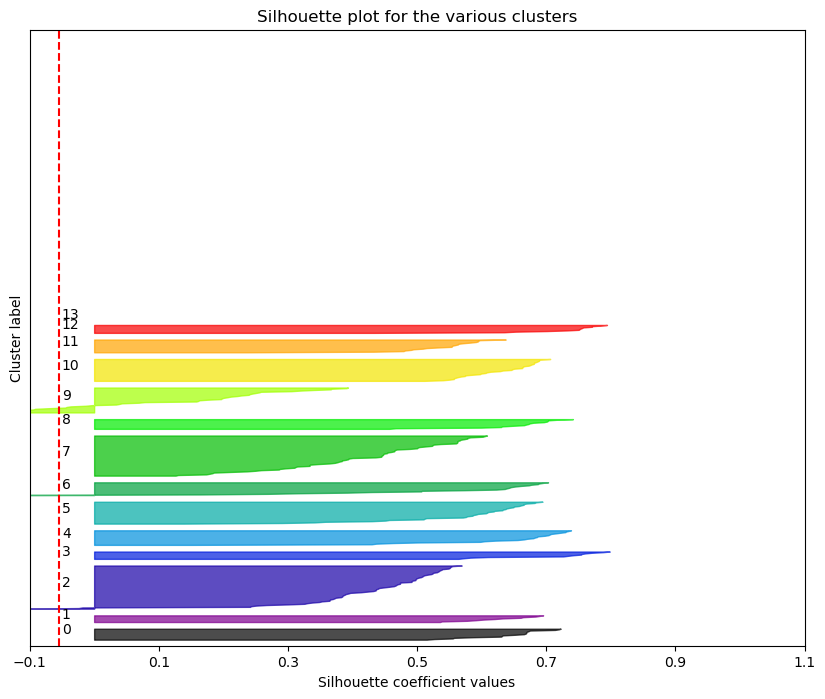

In [172]:
# Clustering
#import umap
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

model = SentenceTransformer("all-MiniLM-L6-v2", similarity_fn_name=SimilarityFunction.COSINE, device=0)


df_filter = df_exploded[ df_exploded['challennge']== 'challenge'].copy()
sentences = df_filter['sentences'].to_list()
embeddings = model.encode(sentences)

#reduce the dimensionality of the embeddings
umap_embeddings = umap.UMAP(n_neighbors=25, n_components=10, metric='cosine').fit_transform(embeddings)

# perform clustering on the reduced embeddings
cluster = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

# extract the cluster labels
df_filter['cluster'] = cluster.labels_



cluster_labels = cluster.labels_

# Calculate silhouette scores
silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
sample_silhouette_values = silhouette_samples(umap_embeddings, cluster_labels)

# Plot silhouette scores
def plot_silhouette(umap_embeddings, cluster_labels, sample_silhouette_values, silhouette_avg):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 8)
    
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(umap_embeddings) + (len(set(cluster_labels)) + 1) * 10])

    y_lower = 10
    for i in range(len(set(cluster_labels))):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

# Plot the silhouette scores
plot_silhouette(umap_embeddings, cluster_labels, sample_silhouette_values, silhouette_avg)

In [70]:


### inference function
def inference(sentences, model=model, threshold=0.5):
    results = []
    if len(sentences): # sentences != NULL
        encoding = tokenizer(sentences, return_tensors="pt", padding=True)
        outputs = model(**encoding)
        logits = outputs['logits'].sigmoid().cpu().detach().numpy()
        for logit, text in zip(logits, sentences):
            results.append({'sequence':text, 'output': {'challenge': logit[0], 'direction': logit[1]}})
    return results
     

### to play with the model insert your own sentences
sentences = ["we speculate that studying IL-6 will be beneficial.",
             "severe atypical cases of pneumonia emerged and quickly spread worldwide.",
             "in future studies, both PRRs should be tested as the cause for multiple deaths.",
             "IbMADS1-transformed potatoes exhibited tuber morphogenesis in the fibrous roots.",]

results = inference(sentences, model=model)
print(*results, sep='\n')
     


['The aim of this paper is to evaluate the costs and GHG emissions of advanced biofuels production through hydrothermal liquefaction (HTL) of sewage sludge in The Netherlands targeting the marine fuels market.', 'The process evaluated consists of a distributed configuration of regional HTL plants co-located with wastewater treatment plants, with centralized hydrotreating co-located with an existing refinery at the Port of Rotterdam.', 'The process is simulated in ASPEN + based on published experimental data and the mass and energy balances are used as input for techno-economic and environmental evaluation.', 'Lifecycle GHG emissions of the HTL and hydrotreating processes are estimated using consequential modelling principles and background data from the Ecoinvent database and compared with the business-as-usual scenario of sludge mono-incineration and fossil marine fuels production.', 'The results indicate that the HTL + hydrotreating configuration has potential to deliver on-spec mari

### Check countries

In [192]:
from transformers import pipeline

# Load a pre-trained model fine-tuned for NER
model_name = 'dbmdz/bert-large-cased-finetuned-conll03-english'  # A model fine-tuned on CoNLL-03 for NER
nlp_ner = pipeline("ner", model=model_name, tokenizer=model_name)

# Perform NER
text = "Hawking Radiation is a theoretical prediction made by Stephen Hawking."
ner_results = nlp_ner(text)
print(ner_results)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'I-PER', 'score': 0.4695394, 'index': 1, 'word': 'Hawk', 'start': 0, 'end': 4}, {'entity': 'I-MISC', 'score': 0.9075718, 'index': 2, 'word': '##ing', 'start': 4, 'end': 7}, {'entity': 'I-MISC', 'score': 0.95800185, 'index': 3, 'word': 'Ra', 'start': 8, 'end': 10}, {'entity': 'I-MISC', 'score': 0.43808076, 'index': 4, 'word': '##diation', 'start': 10, 'end': 17}, {'entity': 'I-PER', 'score': 0.99925953, 'index': 11, 'word': 'Stephen', 'start': 54, 'end': 61}, {'entity': 'I-PER', 'score': 0.9979808, 'index': 12, 'word': 'Hawk', 'start': 62, 'end': 66}, {'entity': 'I-PER', 'score': 0.9956766, 'index': 13, 'word': '##ing', 'start': 66, 'end': 69}]


In [201]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "The REpowerEU plan prioritizes combining electrification with low-carbon hydrogen for a green energy shift. However, uncertainties surrounding the future hydrogen market and its supply costs impede the establishment of its value chain. Without definite plans for hydrogen production and infrastructure, investing in low-carbon hydrogen industrial processes is risky. Simultaneously, the absence of solid market interest poses challenges in deploying a hydrogen backbone. In recent years, European gas Transmission System Operators (TSOs) in Belgium, Netherlands, and Germany, have introduced various roadmaps for their prospective national hydrogen network. Despite the infrastructure proposals, detailed quantitative scenario analysis for the future hydrogen supply chain is still missing. This paper presents a hydrogen infrastructure model that employs Mixed Integer Linear Programming (MILP) for investment and operational cost optimization at detailed spatiotemporal resolution. A regionalization method is proposed to allocate the potential hydrogen consumption in different industrial sectors across various clusters within a country, represented as the prospective hydrogen demand nodes. The model assesses extreme supply scenarios to examine the robustness of the resulting network infrastructure and compare the system-levelized cost of hydrogen. A real-life case study focusing on the potential Belgian hydrogen supply chain showcases the model's capabilities and outputs. "

ner_results = nlp(example)
# Create table with word, entity
entities = [(entity['word'], entity['entity']) for entity in ner_results]
df_result = pd.DataFrame(entities, columns=['word', 'entity'])
print(df_result)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


           word  entity
0             R   B-ORG
1           ##E   I-ORG
2       ##power   I-ORG
3           ##E   I-ORG
4           ##U   I-ORG
5      European  B-MISC
6        System  I-MISC
7         Opera   I-ORG
8        ##tors   I-ORG
9       Belgium   B-LOC
10  Netherlands   B-LOC
11      Germany   B-LOC
12           In  I-MISC
13         ##te  I-MISC
14        ##ger  I-MISC
15         Line  I-MISC
16         ##ar  I-MISC
17  Programming  I-MISC
18      Belgian  B-MISC


In [230]:
from gliner import GLiNER

model = GLiNER.from_pretrained("EmergentMethods/gliner_medium_news-v2.1", device=0)

labels = ['person', "location", "date", "event", "facility", "vehicle", "number", "organization", 'country', 'software']

entities = model.predict_entities(example, labels)

entities = [(entity['text'], entity['label']) for entity in entities]
df_result_2 = pd.DataFrame(entities, columns=['word', 'entity'])
print(df_result_2)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

/home/killa1994/.conda/envs/envThesis/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/home/killa1994/.conda/envs/envThesis/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/killa1994/.local/lib/python3.12/site-packages/gliner/model.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default va

           word    entity
0       Germany   country
1       Germany   country
2        Norway   country
3         Spain   country
4       Algeria   country
5       Morocco   country
6         Egypt   country
7          2050      date
8   Monte Carlo  software
9        Norway   country
10        Spain   country
11      Algeria   country
12      Morocco   country
13      Germany   country
14       Norway   country


In [236]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

example = "The production of green hydrogen through electrolysis, utilizing renewable energies, is recognized as a pivotal element in the pursuit of decarbonization. In order to attain cost competitiveness for green hydrogen, reasonable generation costs are imperative. To identify cost-effective import partners for Germany, given its limited green hydrogen production capabilities, this study undertakes an exhaustive techno-economic analysis to determine the potential Levelized Cost of Hydrogen in Germany, Norway, Spain, Algeria, Morocco, and Egypt for the year 2050, which represents a critical milestone in European decarbonization efforts. Employing a stochastic approach with Monte Carlo simulations, the paper marks a significant contribution for projecting future cost ranges, acknowledging the multitude of uncertainties inherent in related cost parameters and emphasizing the importance of randomness in these assessments. Country-specific Weighted Average Cost of Capital are calculated in order to create a refined understanding of political and economic influences on cost formation, rather than using a uniform value across all investigated nations. Key findings reveal that among the evaluated nations, PV-based hydrogen emerges as the most cost-efficient alternative in all countries except Norway, with Spain presenting the lowest Levelized Cost of Hydrogen at 1.66 €/kg to 3.12 €/kg, followed by Algeria (1.72 €/kg to 3.23 €/kg) and Morocco (1.73 €/kg to 3.28 €/kg). Consequently, for economically favorable import options, Germany is advised to prioritize PV-based hydrogen imports from these countries. Additionally, hydrogen derived from onshore wind in Norway (2.24 €/kg to 3.73 €/kg) offers a feasible import alternative. To ensure supply chain diversity and reduce dependency on a single source, a mixed import strategy is advisable. Despite having the lowest electricity cost, Egypt shows the highest Levelized Cost of Hydrogen, primarily due to a significant Weighted Average Cost of Capital. "

ner_results = nlp(example)
entities = [(entity['word'], entity['entity_group']) for entity in ner_results]
df_result_2 = pd.DataFrame(entities, columns=['word', 'entity'])
print(df_result_2)

/home/killa1994/.conda/envs/envThesis/lib/python3.12/site-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


                                word entity
0                            Germany    LOC
1         Levelized Cost of Hydrogen   MISC
2                            Germany    LOC
3                             Norway    LOC
4                              Spain    LOC
5                            Algeria    LOC
6                            Morocco    LOC
7                              Egypt    LOC
8                           European   MISC
9                        Monte Carlo   MISC
10  Weighted Average Cost of Capital   MISC
11                            Norway    LOC
12                             Spain    LOC
13        Levelized Cost of Hydrogen   MISC
14                           Algeria    LOC
15                           Morocco    LOC
16                           Germany    LOC
17                            Norway    LOC
18                             Egypt    LOC
19        Levelized Cost of Hydrogen   MISC
20  Weighted Average Cost of Capital   MISC


In [237]:
from flair.data import Sentence
from flair.nn import Classifier

# make a sentence
sentence = Sentence(example)

# load the NER tagger
tagger = Classifier.load('ner-large')

# run NER over sentence
tagger.predict(sentence)

# print the sentence with all annotations
print(sentence)

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2024-08-08 21:30:08,894 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Sentence[331]: "The production of green hydrogen through electrolysis, utilizing renewable energies, is recognized as a pivotal element in the pursuit of decarbonization. In order to attain cost competitiveness for green hydrogen, reasonable generation costs are imperative. To identify cost-effective import partners for Germany, given its limited green hydrogen production capabilities, this study undertakes an exhaustive techno-economic analysis to determine the potential Levelized Cost of Hydrogen in Germany, Norway, Spain, Algeria, Morocco, and Egypt for the year 2050, which represents a critical milestone in European decarbonization efforts. Employing a stochastic approach with Monte Carlo simulations, the paper marks a significant contribution for projecting future cost

In [239]:
from flair.nn import Classifier
from flair.splitter import SegtokSentenceSplitter

# initialize sentence splitter
splitter = SegtokSentenceSplitter()

# use splitter to split text into list of sentences
sentences = splitter.split(example)

# predict tags for sentences
tagger = Classifier.load('linker')
tagger.predict(sentences)

# iterate through sentences and print predicted labels
for sentence in sentences:
    print(sentence)

2024-08-08 21:32:10,999 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2024-08-08 21:32:11,283 https://nlp.informatik.hu-berlin.de/resources/models/zelda/v2/zelda-v2.pt not found in cache, downloading to /tmp/tmpi9xv0tse


100%|██████████| 1.76G/1.76G [00:57<00:00, 32.8MB/s]

2024-08-08 21:33:09,101 copying /tmp/tmpi9xv0tse to cache at /home/killa1994/.flair/models/zelda-v2.pt


2024-08-08 21:33:10,308 removing temp file /tmp/tmpi9xv0tse
2024-08-08 21:33:19,210 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Sentence[24]: "The production of green hydrogen through electrolysis, utilizing renewable energies, is recognized as a pivotal element in the pursuit of decarbonization."
Sentence[16]: "In order to attain cost competitiveness for green hydrogen, reasonable generation costs are imperative."
Sentence[59]: "To identify cost-effective import partners for Germany, given its limited green hydrogen production capabilities, this study undertakes an exhaustive techno-economic analysis to determine the potential Levelized Cost of Hydrogen in Germany, Norway, Spain, Algeria, Morocco, and Egypt for the year 2050, which represents a critical milestone in European decarbonization efforts." → ["Germany"/Germany, "Germany"/Germany

In [252]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load model
tagger = SequenceTagger.load("flair/chunk-english-fast")

# make English sentence
sentence = Sentence("This literature review critically examines the current advantages and strategies adopted by the GCC to expedite the implementation of hydrogen supply chains, as well as investigation into the methodologies employed in current research for the modelling and optimisation of hydrogen supply chains.")

# predict NER tags
tagger.predict(sentence)

# print the chunks
for chunk in sentence.get_spans('np'):
  print(chunk)

2024-08-08 22:03:32,707 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>
Span[0:3]: "This literature review" → NP (0.9740)
Span[3:4]: "critically" → ADVP (0.8480)
Span[4:5]: "examines" → VP (0.5869)
Span[5:10]: "the current advantages and strategies" → NP (0.9576)
Span[10:11]: "adopted" → VP (0.9999)
Span[11:12]: "by" → PP (0.9999)
Span[12:14]: "the GCC" → NP (0.9996)
Span[14:16]: "to expedite" → VP (0.9930)
Span[16:18]: "the implementation" → NP (0.9989)
Span[18:19]: "of" → PP (1.0000)
Span[19:22]: "hydrogen supply chains" → NP (0.8397)
Span[23:26]: "as well as" → CONJP (0.9895)
Span[26:27]: "investigation" → NP (1.0000)
Span[27:28]: "into" → PP (1.00

In [249]:
from flair.data import Sentence
from flair.nn import Classifier

# 1. make example sentence
sentence = Sentence("This literature review critically examines the current advantages and strategies adopted by the GCC to expedite the implementation of hydrogen supply chains, as well as investigation into the methodologies employed in current research for the modelling and optimisation of hydrogen supply chains.")

# 2. load entity tagger and predict entities
tagger = Classifier.load('ner-fast')
tagger.predict(sentence)

# check which named entities have been found in the sentence
entities = sentence.get_labels('ner')
for entity in entities:
    print(entity)

# 3. load relation extractor
extractor = Classifier.load('relations')

# predict relations
extractor.predict(sentence)

# check which relations have been found
relations = sentence.get_labels('relation')
for relation in relations:
    print(relation)

# Use the `get_labels()` method with parameter 'relation' to iterate over all relation predictions. 
for label in sentence.get_labels('relation'):
    print(label)

2024-08-08 21:57:12,713 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Span[13:14]: "GCC" → ORG (0.9928)
